In [6]:
import os
import random
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from ptflops import get_model_complexity_info
import optuna
from tqdm import tqdm
import timm

In [7]:
# Data paths based on the provided file structure
BASE_DIR = '/home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset'
TRAIN_SET_DIR = os.path.join(BASE_DIR, 'Train_set')
AUG_SET_DIR = os.path.join(BASE_DIR, 'Augmented_Set')
TEST_SET_DIR = os.path.join(BASE_DIR, 'Test_set')

In [8]:
# Model & Training Parameters
RANDOM_STATE = 42
IMG_SIZE = 256
CROP_SIZE = 224
BATCH_SIZE = 32
N_OPTUNA_TRIALS = 20  
OPTUNA_EPOCHS = 25     
FULL_TRAIN_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10 

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs('./mnasnet_outputs', exist_ok=True)



Using device: cuda


In [10]:
# --- 2. Data Loading and Preparation ---
def load_image_paths(directories):
    """Loads image paths and labels from a list of directories."""
    all_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(directories[0]) if os.path.isdir(os.path.join(directories[0], d))])
    class_to_int = {name: i for i, name in enumerate(class_names)}
    int_to_class = {i: name for i, name in enumerate(class_names)}

    for directory in directories:
        for class_name in class_names:
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            image_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_paths.extend(image_files)
            all_labels.extend([class_to_int[class_name]] * len(image_files))
    return all_paths, all_labels, class_to_int, int_to_class

print("--- Loading Data ---")
# Combine original train and augmented sets for the training pool
train_val_paths, train_val_labels, class_to_int, int_to_class = load_image_paths([TRAIN_SET_DIR, AUG_SET_DIR])
test_paths, test_labels, _, _ = load_image_paths([TEST_SET_DIR])
num_classes = len(class_to_int)

print(f"Found {num_classes} classes: {list(class_to_int.keys())}")

--- Loading Data ---
Found 17 classes: ['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Eye_Spot', 'Grassy_Shoot', 'Healthy', 'Mosaic', 'Pokkah_Boeng', 'RedRot', 'Red_Leaf_Spot', 'Ring_Spot', 'Rust', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']


In [11]:
# Stratified split for train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=RANDOM_STATE
)

print(f"Total training pool images: {len(train_val_paths)}")
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

Total training pool images: 11314
Training samples: 9051
Validation samples: 2263
Test samples: 1414


In [12]:
class SugarcaneLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
        
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SugarcaneLeafDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SugarcaneLeafDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = SugarcaneLeafDataset(test_paths, test_labels, transform=val_test_transform)

# Handle class imbalance for training loader with WeightedRandomSampler
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in train_labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
# --- 3. Model Definition (MnasNet with Timm) ---
class RegularizedMnasNet(nn.Module):
    """
    A regularized MnasNet model using the timm library.
    This class loads a pretrained MnasNet, freezes a portion of its layers,
    and attaches a new custom classifier head.
    """
    def __init__(self, num_classes, dropout_rate1=0.5, dropout_rate2=0.5, freeze_ratio=0.5):
        super().__init__()
        self.timm_model_name = 'mnasnet_100' # <-- Changed to MnasNet
        
        # Load the base model from timm with pretrained weights.
        # num_classes=0 removes the original classifier head.
        self.base_model = timm.create_model(self.timm_model_name, pretrained=True, num_classes=0)
        print(f"Loaded '{self.timm_model_name}' from timm with pretrained weights.")

        # Freeze layers based on the freeze_ratio
        all_params = list(self.base_model.parameters())
        num_to_freeze = int(len(all_params) * freeze_ratio)
        if num_to_freeze > 0:
            print(f"Freezing the first {num_to_freeze} of {len(all_params)} parameter groups.")
            for i, param in enumerate(all_params):
                if i < num_to_freeze:
                    param.requires_grad = False
        
        # Get the number of input features for the classifier
        in_features = self.base_model.num_features
        print(f"Base model feature dimension: {in_features}")
        
        # Replace the model's classifier with a new custom head
        # MnasNet in timm also uses 'classifier' for its head
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate1),
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout_rate2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [14]:
# --- 4. Training & Evaluation Functions ---
def train_epoch(model, loader, criterion, optimizer, device, grad_clip_norm=1.0):
    model.train()
    running_loss = 0.0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

In [15]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets, all_outputs = [], [], []
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    loss = running_loss / len(loader.dataset)
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    return loss, accuracy, all_preds, all_targets, np.array(all_outputs)

In [16]:
# --- 5. Hyperparameter Tuning with Optuna ---
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate1 = trial.suggest_float("dropout_rate1", 0.1, 0.6)
    dropout_rate2 = trial.suggest_float("dropout_rate2", 0.1, 0.6)
    freeze_ratio = trial.suggest_float("freeze_ratio", 0.0, 0.8)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)
    grad_clip = trial.suggest_float("grad_clip", 0.5, 2.0)

    # Model, Optimizer, Criterion
    model = RegularizedMnasNet(num_classes, dropout_rate1, dropout_rate2, freeze_ratio).to(device) # <-- Use MnasNet class
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Training loop for the trial
    for epoch in range(OPTUNA_EPOCHS):
        train_epoch(model, train_loader, criterion, optimizer, device, grad_clip)
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
        
        print(f"Trial {trial.number} | Epoch {epoch+1}/{OPTUNA_EPOCHS} | Val Acc: {val_acc:.2f}%")
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc

In [17]:
print("\n--- Starting Hyperparameter Optimization with Optuna ---")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=N_OPTUNA_TRIALS) 

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value:.2f}%")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
best_hyperparams = best_trial.params

# --- 6. Final Model Training ---
print("\n--- Starting Final Training with Best Hyperparameters ---")
final_model = RegularizedMnasNet( # <-- Use MnasNet class
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)

final_optimizer = getattr(torch.optim, best_hyperparams["optimizer"])(
    final_model.parameters(), lr=best_hyperparams["lr"], weight_decay=best_hyperparams["weight_decay"]
)
final_criterion = nn.CrossEntropyLoss(label_smoothing=best_hyperparams["label_smoothing"])
final_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=FULL_TRAIN_EPOCHS)

[I 2025-07-18 03:40:47,390] A new study created in memory with name: no-name-465bea9a-f1d8-4b3b-94fe-76a3339a805b



--- Starting Hyperparameter Optimization with Optuna ---


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 72 of 156 parameter groups.
Base model feature dimension: 1280
Trial 0 | Epoch 1/25 | Val Acc: 62.40%
Trial 0 | Epoch 2/25 | Val Acc: 79.41%
Trial 0 | Epoch 3/25 | Val Acc: 86.12%
Trial 0 | Epoch 4/25 | Val Acc: 90.23%
Trial 0 | Epoch 5/25 | Val Acc: 92.80%
Trial 0 | Epoch 6/25 | Val Acc: 93.46%
Trial 0 | Epoch 7/25 | Val Acc: 94.79%
Trial 0 | Epoch 8/25 | Val Acc: 94.92%
Trial 0 | Epoch 9/25 | Val Acc: 95.85%
Trial 0 | Epoch 10/25 | Val Acc: 96.24%
Trial 0 | Epoch 11/25 | Val Acc: 96.07%
Trial 0 | Epoch 12/25 | Val Acc: 96.69%
Trial 0 | Epoch 13/25 | Val Acc: 96.60%
Trial 0 | Epoch 14/25 | Val Acc: 96.82%
Trial 0 | Epoch 15/25 | Val Acc: 97.00%
Trial 0 | Epoch 16/25 | Val Acc: 97.22%
Trial 0 | Epoch 17/25 | Val Acc: 97.26%
Trial 0 | Epoch 18/25 | Val Acc: 97.44%
Trial 0 | Epoch 19/25 | Val Acc: 97.57%
Trial 0 | Epoch 20/25 | Val Acc: 97.75%
Trial 0 | Epoch 21/25 | Val Acc: 97.83%
Trial 0 | Epoch 22/25 | Val Acc

[I 2025-07-18 04:08:49,188] Trial 0 finished with value: 98.09986743261157 and parameters: {'lr': 1.6704340028095234e-05, 'optimizer': 'Adam', 'weight_decay': 2.3972861285674934e-06, 'dropout_rate1': 0.28411614321106105, 'dropout_rate2': 0.46242326995721206, 'freeze_ratio': 0.46709309205274385, 'label_smoothing': 0.09278682975289732, 'grad_clip': 1.4050472001202747}. Best is trial 0 with value: 98.09986743261157.


Trial 0 | Epoch 25/25 | Val Acc: 98.10%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 32 of 156 parameter groups.
Base model feature dimension: 1280
Trial 1 | Epoch 1/25 | Val Acc: 87.36%
Trial 1 | Epoch 2/25 | Val Acc: 93.15%
Trial 1 | Epoch 3/25 | Val Acc: 96.07%
Trial 1 | Epoch 4/25 | Val Acc: 96.33%
Trial 1 | Epoch 5/25 | Val Acc: 97.22%
Trial 1 | Epoch 6/25 | Val Acc: 97.79%
Trial 1 | Epoch 7/25 | Val Acc: 97.75%
Trial 1 | Epoch 8/25 | Val Acc: 97.79%
Trial 1 | Epoch 9/25 | Val Acc: 98.19%
Trial 1 | Epoch 10/25 | Val Acc: 98.45%
Trial 1 | Epoch 11/25 | Val Acc: 98.45%
Trial 1 | Epoch 12/25 | Val Acc: 98.32%
Trial 1 | Epoch 13/25 | Val Acc: 98.50%
Trial 1 | Epoch 14/25 | Val Acc: 98.45%
Trial 1 | Epoch 15/25 | Val Acc: 98.45%
Trial 1 | Epoch 16/25 | Val Acc: 98.37%
Trial 1 | Epoch 17/25 | Val Acc: 98.45%
Trial 1 | Epoch 18/25 | Val Acc: 98.32%
Trial 1 | Epoch 19/25 | Val Acc: 98.59%
Trial 1 | Epoch 20/25 | Val Acc: 98.63%
Trial 1 | Epoch 21/25 | Val Acc

[I 2025-07-18 04:37:37,298] Trial 1 finished with value: 98.76270437472382 and parameters: {'lr': 7.439938433243066e-05, 'optimizer': 'Adam', 'weight_decay': 1.2622094457721738e-05, 'dropout_rate1': 0.4285707210930567, 'dropout_rate2': 0.5778557904035505, 'freeze_ratio': 0.20956674830685112, 'label_smoothing': 0.0381382153316997, 'grad_clip': 0.634999410448887}. Best is trial 1 with value: 98.76270437472382.


Trial 1 | Epoch 25/25 | Val Acc: 98.76%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 52 of 156 parameter groups.
Base model feature dimension: 1280
Trial 2 | Epoch 1/25 | Val Acc: 79.58%
Trial 2 | Epoch 2/25 | Val Acc: 86.12%
Trial 2 | Epoch 3/25 | Val Acc: 85.29%
Trial 2 | Epoch 4/25 | Val Acc: 90.63%
Trial 2 | Epoch 5/25 | Val Acc: 89.09%
Trial 2 | Epoch 6/25 | Val Acc: 94.17%
Trial 2 | Epoch 7/25 | Val Acc: 92.27%
Trial 2 | Epoch 8/25 | Val Acc: 92.62%
Trial 2 | Epoch 9/25 | Val Acc: 93.11%
Trial 2 | Epoch 10/25 | Val Acc: 93.95%
Trial 2 | Epoch 11/25 | Val Acc: 94.12%
Trial 2 | Epoch 12/25 | Val Acc: 93.95%
Trial 2 | Epoch 13/25 | Val Acc: 95.45%
Trial 2 | Epoch 14/25 | Val Acc: 95.85%
Trial 2 | Epoch 15/25 | Val Acc: 95.98%
Trial 2 | Epoch 16/25 | Val Acc: 95.98%
Trial 2 | Epoch 17/25 | Val Acc: 94.65%
Trial 2 | Epoch 18/25 | Val Acc: 95.36%
Trial 2 | Epoch 19/25 | Val Acc: 95.01%
Trial 2 | Epoch 20/25 | Val Acc: 95.23%
Trial 2 | Epoch 21/25 | Val Acc

[I 2025-07-18 05:06:36,592] Trial 2 finished with value: 96.02297834732656 and parameters: {'lr': 0.002708417278667275, 'optimizer': 'AdamW', 'weight_decay': 5.721345247720542e-05, 'dropout_rate1': 0.10833533187723934, 'dropout_rate2': 0.4456349354843172, 'freeze_ratio': 0.3377675044056099, 'label_smoothing': 0.0014636291537251768, 'grad_clip': 1.1667311566551497}. Best is trial 1 with value: 98.76270437472382.


Trial 2 | Epoch 25/25 | Val Acc: 96.02%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 6 of 156 parameter groups.
Base model feature dimension: 1280
Trial 3 | Epoch 1/25 | Val Acc: 14.76%
Trial 3 | Epoch 2/25 | Val Acc: 14.36%
Trial 3 | Epoch 3/25 | Val Acc: 31.11%
Trial 3 | Epoch 4/25 | Val Acc: 40.96%
Trial 3 | Epoch 5/25 | Val Acc: 47.95%
Trial 3 | Epoch 6/25 | Val Acc: 49.14%
Trial 3 | Epoch 7/25 | Val Acc: 61.95%
Trial 3 | Epoch 8/25 | Val Acc: 68.05%
Trial 3 | Epoch 9/25 | Val Acc: 69.33%
Trial 3 | Epoch 10/25 | Val Acc: 73.40%
Trial 3 | Epoch 11/25 | Val Acc: 75.03%
Trial 3 | Epoch 12/25 | Val Acc: 72.21%
Trial 3 | Epoch 13/25 | Val Acc: 82.19%
Trial 3 | Epoch 14/25 | Val Acc: 78.88%
Trial 3 | Epoch 15/25 | Val Acc: 79.63%
Trial 3 | Epoch 16/25 | Val Acc: 79.98%
Trial 3 | Epoch 17/25 | Val Acc: 83.56%
Trial 3 | Epoch 18/25 | Val Acc: 84.67%
Trial 3 | Epoch 19/25 | Val Acc: 84.49%
Trial 3 | Epoch 20/25 | Val Acc: 84.31%
Trial 3 | Epoch 21/25 | Val Acc:

[I 2025-07-18 05:34:55,175] Trial 3 finished with value: 86.34555899248785 and parameters: {'lr': 0.008878879950261367, 'optimizer': 'AdamW', 'weight_decay': 0.000437062669631933, 'dropout_rate1': 0.3812157942090132, 'dropout_rate2': 0.40412998519187093, 'freeze_ratio': 0.04242357612822545, 'label_smoothing': 0.1155190574105281, 'grad_clip': 1.0086688004865034}. Best is trial 1 with value: 98.76270437472382.


Trial 3 | Epoch 25/25 | Val Acc: 86.35%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 115 of 156 parameter groups.
Base model feature dimension: 1280
Trial 4 | Epoch 1/25 | Val Acc: 73.31%
Trial 4 | Epoch 2/25 | Val Acc: 88.86%
Trial 4 | Epoch 3/25 | Val Acc: 91.38%
Trial 4 | Epoch 4/25 | Val Acc: 95.45%
Trial 4 | Epoch 5/25 | Val Acc: 95.27%
Trial 4 | Epoch 6/25 | Val Acc: 96.29%
Trial 4 | Epoch 7/25 | Val Acc: 96.33%
Trial 4 | Epoch 8/25 | Val Acc: 94.65%
Trial 4 | Epoch 9/25 | Val Acc: 95.71%
Trial 4 | Epoch 10/25 | Val Acc: 95.54%
Trial 4 | Epoch 11/25 | Val Acc: 96.64%
Trial 4 | Epoch 12/25 | Val Acc: 96.07%
Trial 4 | Epoch 13/25 | Val Acc: 96.16%
Trial 4 | Epoch 14/25 | Val Acc: 97.17%
Trial 4 | Epoch 15/25 | Val Acc: 96.07%
Trial 4 | Epoch 16/25 | Val Acc: 96.91%
Trial 4 | Epoch 17/25 | Val Acc: 96.64%
Trial 4 | Epoch 18/25 | Val Acc: 96.82%
Trial 4 | Epoch 19/25 | Val Acc: 96.02%
Trial 4 | Epoch 20/25 | Val Acc: 97.57%
Trial 4 | Epoch 21/25 | Val Ac

[I 2025-07-18 06:03:41,027] Trial 4 finished with value: 96.73000441891294 and parameters: {'lr': 0.006858888246119438, 'optimizer': 'AdamW', 'weight_decay': 0.004798912704854911, 'dropout_rate1': 0.3441780025344665, 'dropout_rate2': 0.1449712737809363, 'freeze_ratio': 0.7410007526904159, 'label_smoothing': 0.1998008433292386, 'grad_clip': 1.1918555851657469}. Best is trial 1 with value: 98.76270437472382.


Trial 4 | Epoch 25/25 | Val Acc: 96.73%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 34 of 156 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 06:04:46,402] Trial 5 pruned. 


Trial 5 | Epoch 1/25 | Val Acc: 35.26%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 65 of 156 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 06:05:58,060] Trial 6 pruned. 


Trial 6 | Epoch 1/25 | Val Acc: 57.76%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 102 of 156 parameter groups.
Base model feature dimension: 1280
Trial 7 | Epoch 1/25 | Val Acc: 92.18%
Trial 7 | Epoch 2/25 | Val Acc: 95.71%
Trial 7 | Epoch 3/25 | Val Acc: 96.38%
Trial 7 | Epoch 4/25 | Val Acc: 96.73%
Trial 7 | Epoch 5/25 | Val Acc: 97.66%
Trial 7 | Epoch 6/25 | Val Acc: 97.88%
Trial 7 | Epoch 7/25 | Val Acc: 98.32%
Trial 7 | Epoch 8/25 | Val Acc: 98.28%
Trial 7 | Epoch 9/25 | Val Acc: 98.06%
Trial 7 | Epoch 10/25 | Val Acc: 98.19%
Trial 7 | Epoch 11/25 | Val Acc: 97.97%
Trial 7 | Epoch 12/25 | Val Acc: 98.45%
Trial 7 | Epoch 13/25 | Val Acc: 98.76%
Trial 7 | Epoch 14/25 | Val Acc: 98.32%
Trial 7 | Epoch 15/25 | Val Acc: 98.54%
Trial 7 | Epoch 16/25 | Val Acc: 98.59%
Trial 7 | Epoch 17/25 | Val Acc: 98.59%
Trial 7 | Epoch 18/25 | Val Acc: 98.23%
Trial 7 | Epoch 19/25 | Val Acc: 98.06%
Trial 7 | Epoch 20/25 | Val Acc: 98.50%
Trial 7 | Epoch 21/25 | Val Acc

[I 2025-07-18 06:31:41,090] Trial 7 finished with value: 98.36500220945648 and parameters: {'lr': 0.00015433994839953008, 'optimizer': 'AdamW', 'weight_decay': 2.383463172022921e-05, 'dropout_rate1': 0.2629581574006923, 'dropout_rate2': 0.3859610710818976, 'freeze_ratio': 0.6547746568384586, 'label_smoothing': 0.03019010022571338, 'grad_clip': 0.7634957088176697}. Best is trial 1 with value: 98.76270437472382.


Trial 7 | Epoch 25/25 | Val Acc: 98.37%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 24 of 156 parameter groups.
Base model feature dimension: 1280
Trial 8 | Epoch 1/25 | Val Acc: 89.17%
Trial 8 | Epoch 2/25 | Val Acc: 94.83%
Trial 8 | Epoch 3/25 | Val Acc: 95.18%
Trial 8 | Epoch 4/25 | Val Acc: 96.02%
Trial 8 | Epoch 5/25 | Val Acc: 96.69%
Trial 8 | Epoch 6/25 | Val Acc: 96.38%
Trial 8 | Epoch 7/25 | Val Acc: 96.82%
Trial 8 | Epoch 8/25 | Val Acc: 97.61%
Trial 8 | Epoch 9/25 | Val Acc: 96.77%
Trial 8 | Epoch 10/25 | Val Acc: 96.55%
Trial 8 | Epoch 11/25 | Val Acc: 96.55%
Trial 8 | Epoch 12/25 | Val Acc: 97.44%
Trial 8 | Epoch 13/25 | Val Acc: 97.30%
Trial 8 | Epoch 14/25 | Val Acc: 96.95%
Trial 8 | Epoch 15/25 | Val Acc: 97.61%
Trial 8 | Epoch 16/25 | Val Acc: 96.86%
Trial 8 | Epoch 17/25 | Val Acc: 97.48%
Trial 8 | Epoch 18/25 | Val Acc: 97.08%
Trial 8 | Epoch 19/25 | Val Acc: 97.26%


[I 2025-07-18 06:53:16,391] Trial 8 pruned. 


Trial 8 | Epoch 20/25 | Val Acc: 96.55%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 49 of 156 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 06:54:20,873] Trial 9 pruned. 


Trial 9 | Epoch 1/25 | Val Acc: 38.62%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 87 of 156 parameter groups.
Base model feature dimension: 1280
Trial 10 | Epoch 1/25 | Val Acc: 89.75%
Trial 10 | Epoch 2/25 | Val Acc: 94.70%
Trial 10 | Epoch 3/25 | Val Acc: 96.11%
Trial 10 | Epoch 4/25 | Val Acc: 96.51%
Trial 10 | Epoch 5/25 | Val Acc: 97.57%
Trial 10 | Epoch 6/25 | Val Acc: 97.39%
Trial 10 | Epoch 7/25 | Val Acc: 98.28%
Trial 10 | Epoch 8/25 | Val Acc: 98.23%
Trial 10 | Epoch 9/25 | Val Acc: 97.97%
Trial 10 | Epoch 10/25 | Val Acc: 98.32%
Trial 10 | Epoch 11/25 | Val Acc: 98.41%
Trial 10 | Epoch 12/25 | Val Acc: 97.92%
Trial 10 | Epoch 13/25 | Val Acc: 98.54%
Trial 10 | Epoch 14/25 | Val Acc: 98.63%
Trial 10 | Epoch 15/25 | Val Acc: 98.54%
Trial 10 | Epoch 16/25 | Val Acc: 98.67%
Trial 10 | Epoch 17/25 | Val Acc: 98.32%
Trial 10 | Epoch 18/25 | Val Acc: 98.54%
Trial 10 | Epoch 19/25 | Val Acc: 98.10%
Trial 10 | Epoch 20/25 | Val Acc: 98.54%
Trial 10 | E

[I 2025-07-18 07:22:57,883] Trial 10 finished with value: 98.63013698630137 and parameters: {'lr': 0.0001285881257879187, 'optimizer': 'Adam', 'weight_decay': 1.3547619878491893e-06, 'dropout_rate1': 0.5990346214353176, 'dropout_rate2': 0.5933919606317273, 'freeze_ratio': 0.5598363112375796, 'label_smoothing': 0.05060293640711745, 'grad_clip': 1.5593614763080819}. Best is trial 1 with value: 98.76270437472382.


Trial 10 | Epoch 25/25 | Val Acc: 98.63%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 85 of 156 parameter groups.
Base model feature dimension: 1280
Trial 11 | Epoch 1/25 | Val Acc: 84.89%
Trial 11 | Epoch 2/25 | Val Acc: 92.58%
Trial 11 | Epoch 3/25 | Val Acc: 95.10%
Trial 11 | Epoch 4/25 | Val Acc: 96.38%
Trial 11 | Epoch 5/25 | Val Acc: 96.11%
Trial 11 | Epoch 6/25 | Val Acc: 96.95%
Trial 11 | Epoch 7/25 | Val Acc: 97.70%
Trial 11 | Epoch 8/25 | Val Acc: 97.53%
Trial 11 | Epoch 9/25 | Val Acc: 98.23%
Trial 11 | Epoch 10/25 | Val Acc: 98.01%
Trial 11 | Epoch 11/25 | Val Acc: 97.70%
Trial 11 | Epoch 12/25 | Val Acc: 97.88%
Trial 11 | Epoch 13/25 | Val Acc: 98.14%
Trial 11 | Epoch 14/25 | Val Acc: 98.06%
Trial 11 | Epoch 15/25 | Val Acc: 98.41%
Trial 11 | Epoch 16/25 | Val Acc: 98.37%
Trial 11 | Epoch 17/25 | Val Acc: 98.41%
Trial 11 | Epoch 18/25 | Val Acc: 98.19%
Trial 11 | Epoch 19/25 | Val Acc: 98.41%
Trial 11 | Epoch 20/25 | Val Acc: 97.88%
Trial 11 |

[I 2025-07-18 07:47:30,568] Trial 11 finished with value: 98.05567830313743 and parameters: {'lr': 8.772833062365275e-05, 'optimizer': 'Adam', 'weight_decay': 1.3081007002697108e-06, 'dropout_rate1': 0.5920660227091725, 'dropout_rate2': 0.5824853887157333, 'freeze_ratio': 0.5469299985160969, 'label_smoothing': 0.0485810114261513, 'grad_clip': 1.5677727372008814}. Best is trial 1 with value: 98.76270437472382.


Trial 11 | Epoch 25/25 | Val Acc: 98.06%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 89 of 156 parameter groups.
Base model feature dimension: 1280
Trial 12 | Epoch 1/25 | Val Acc: 85.02%
Trial 12 | Epoch 2/25 | Val Acc: 93.50%
Trial 12 | Epoch 3/25 | Val Acc: 94.83%


[I 2025-07-18 07:50:48,806] Trial 12 pruned. 


Trial 12 | Epoch 4/25 | Val Acc: 95.85%
Loaded 'mnasnet_100' from timm with pretrained weights.
Base model feature dimension: 1280
Trial 13 | Epoch 1/25 | Val Acc: 92.93%
Trial 13 | Epoch 2/25 | Val Acc: 94.92%
Trial 13 | Epoch 3/25 | Val Acc: 95.71%
Trial 13 | Epoch 4/25 | Val Acc: 96.82%
Trial 13 | Epoch 5/25 | Val Acc: 98.06%
Trial 13 | Epoch 6/25 | Val Acc: 97.79%
Trial 13 | Epoch 7/25 | Val Acc: 98.41%
Trial 13 | Epoch 8/25 | Val Acc: 97.57%
Trial 13 | Epoch 9/25 | Val Acc: 97.57%
Trial 13 | Epoch 10/25 | Val Acc: 97.97%
Trial 13 | Epoch 11/25 | Val Acc: 97.88%
Trial 13 | Epoch 12/25 | Val Acc: 97.53%
Trial 13 | Epoch 13/25 | Val Acc: 98.23%
Trial 13 | Epoch 14/25 | Val Acc: 98.19%
Trial 13 | Epoch 15/25 | Val Acc: 97.30%
Trial 13 | Epoch 16/25 | Val Acc: 97.53%
Trial 13 | Epoch 17/25 | Val Acc: 98.37%
Trial 13 | Epoch 18/25 | Val Acc: 98.67%
Trial 13 | Epoch 19/25 | Val Acc: 98.59%
Trial 13 | Epoch 20/25 | Val Acc: 98.28%
Trial 13 | Epoch 21/25 | Val Acc: 98.28%
Trial 13 | Epoch 

[I 2025-07-18 08:09:50,155] Trial 13 finished with value: 98.05567830313743 and parameters: {'lr': 0.00028933290111294116, 'optimizer': 'Adam', 'weight_decay': 6.046580973525341e-06, 'dropout_rate1': 0.5978502679308604, 'dropout_rate2': 0.5213220927877754, 'freeze_ratio': 0.0041354319210684665, 'label_smoothing': 0.0643322676958048, 'grad_clip': 1.8046439054764989}. Best is trial 1 with value: 98.76270437472382.


Trial 13 | Epoch 25/25 | Val Acc: 98.06%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 28 of 156 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 08:10:33,857] Trial 14 pruned. 


Trial 14 | Epoch 1/25 | Val Acc: 78.75%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 119 of 156 parameter groups.
Base model feature dimension: 1280
Trial 15 | Epoch 1/25 | Val Acc: 90.41%
Trial 15 | Epoch 2/25 | Val Acc: 95.01%
Trial 15 | Epoch 3/25 | Val Acc: 96.33%
Trial 15 | Epoch 4/25 | Val Acc: 96.51%
Trial 15 | Epoch 5/25 | Val Acc: 96.86%
Trial 15 | Epoch 6/25 | Val Acc: 97.22%


[I 2025-07-18 08:15:36,108] Trial 15 pruned. 


Trial 15 | Epoch 7/25 | Val Acc: 97.44%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 42 of 156 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 08:16:15,251] Trial 16 pruned. 


Trial 16 | Epoch 1/25 | Val Acc: 77.91%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 77 of 156 parameter groups.
Base model feature dimension: 1280
Trial 17 | Epoch 1/25 | Val Acc: 90.90%
Trial 17 | Epoch 2/25 | Val Acc: 94.87%
Trial 17 | Epoch 3/25 | Val Acc: 96.60%
Trial 17 | Epoch 4/25 | Val Acc: 97.22%
Trial 17 | Epoch 5/25 | Val Acc: 98.14%
Trial 17 | Epoch 6/25 | Val Acc: 98.32%
Trial 17 | Epoch 7/25 | Val Acc: 98.14%
Trial 17 | Epoch 8/25 | Val Acc: 98.10%
Trial 17 | Epoch 9/25 | Val Acc: 98.67%
Trial 17 | Epoch 10/25 | Val Acc: 98.50%
Trial 17 | Epoch 11/25 | Val Acc: 98.10%
Trial 17 | Epoch 12/25 | Val Acc: 98.41%
Trial 17 | Epoch 13/25 | Val Acc: 98.41%
Trial 17 | Epoch 14/25 | Val Acc: 98.54%
Trial 17 | Epoch 15/25 | Val Acc: 98.45%
Trial 17 | Epoch 16/25 | Val Acc: 98.72%
Trial 17 | Epoch 17/25 | Val Acc: 98.37%
Trial 17 | Epoch 18/25 | Val Acc: 98.32%
Trial 17 | Epoch 19/25 | Val Acc: 98.32%
Trial 17 | Epoch 20/25 | Val Acc: 98.28%
Trial 17 | 

[I 2025-07-18 08:34:09,802] Trial 17 finished with value: 98.54175872735307 and parameters: {'lr': 0.00014984955134629273, 'optimizer': 'Adam', 'weight_decay': 1.6821962470961532e-05, 'dropout_rate1': 0.5390742380258238, 'dropout_rate2': 0.5916395313037389, 'freeze_ratio': 0.4986236282711981, 'label_smoothing': 0.020461168650392342, 'grad_clip': 0.9769993171752407}. Best is trial 1 with value: 98.76270437472382.


Trial 17 | Epoch 25/25 | Val Acc: 98.54%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 104 of 156 parameter groups.
Base model feature dimension: 1280
Trial 18 | Epoch 1/25 | Val Acc: 92.58%
Trial 18 | Epoch 2/25 | Val Acc: 94.87%
Trial 18 | Epoch 3/25 | Val Acc: 96.16%
Trial 18 | Epoch 4/25 | Val Acc: 96.86%
Trial 18 | Epoch 5/25 | Val Acc: 97.92%
Trial 18 | Epoch 6/25 | Val Acc: 97.35%
Trial 18 | Epoch 7/25 | Val Acc: 97.61%
Trial 18 | Epoch 8/25 | Val Acc: 97.13%
Trial 18 | Epoch 9/25 | Val Acc: 97.53%


[I 2025-07-18 08:41:18,437] Trial 18 pruned. 


Trial 18 | Epoch 10/25 | Val Acc: 97.39%
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 62 of 156 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 08:41:57,627] Trial 19 pruned. 


Trial 19 | Epoch 1/25 | Val Acc: 48.52%
Number of finished trials:  20
Best trial:
  Value: 98.76%
  Params: 
    lr: 7.439938433243066e-05
    optimizer: Adam
    weight_decay: 1.2622094457721738e-05
    dropout_rate1: 0.4285707210930567
    dropout_rate2: 0.5778557904035505
    freeze_ratio: 0.20956674830685112
    label_smoothing: 0.0381382153316997
    grad_clip: 0.634999410448887

--- Starting Final Training with Best Hyperparameters ---
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 32 of 156 parameter groups.
Base model feature dimension: 1280


In [18]:
# Calculate and print model complexity
try:
    macs, params = get_model_complexity_info(final_model, (3, CROP_SIZE, CROP_SIZE), as_strings=True, print_per_layer_stat=False, verbose=False)
    print(f"\nFinal Model Complexity: MACs: {macs}, Params: {params}")
except Exception as e:
    print(f"Could not calculate model complexity: {e}")
    
# Training loop with early stopping
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
epochs_no_improve = 0
training_start_time = time.time()


Final Model Complexity: MACs: 324.19 MMac, Params: 4.42 M


In [19]:
for epoch in range(FULL_TRAIN_EPOCHS):
    train_loss = train_epoch(final_model, train_loader, final_criterion, final_optimizer, device, best_hyperparams["grad_clip"])
    _, train_acc, _, _, _ = evaluate(final_model, train_loader, final_criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(final_model, val_loader, final_criterion, device)
    
    final_scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{FULL_TRAIN_EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(final_model.state_dict(), './mnasnet_outputs/best_model.pth') # <-- Save to mnasnet directory
        print("  Validation loss decreased. Model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

total_training_duration = time.time() - training_start_time
print(f"Total final training time: {total_training_duration/60:.2f} minutes.")

Epoch 1/100 | Train Loss: 1.4772, Acc: 91.51% | Val Loss: 0.6516, Acc: 87.45%
  Validation loss decreased. Model saved.
Epoch 2/100 | Train Loss: 0.6261, Acc: 96.61% | Val Loss: 0.5157, Acc: 94.08%
  Validation loss decreased. Model saved.
Epoch 3/100 | Train Loss: 0.4524, Acc: 98.96% | Val Loss: 0.4646, Acc: 96.69%
  Validation loss decreased. Model saved.
Epoch 4/100 | Train Loss: 0.4054, Acc: 99.11% | Val Loss: 0.4425, Acc: 96.69%
  Validation loss decreased. Model saved.
Epoch 5/100 | Train Loss: 0.3694, Acc: 99.57% | Val Loss: 0.4109, Acc: 97.22%
  Validation loss decreased. Model saved.
Epoch 6/100 | Train Loss: 0.3462, Acc: 99.77% | Val Loss: 0.4020, Acc: 97.92%
  Validation loss decreased. Model saved.
Epoch 7/100 | Train Loss: 0.3320, Acc: 99.83% | Val Loss: 0.3823, Acc: 98.06%
  Validation loss decreased. Model saved.
Epoch 8/100 | Train Loss: 0.3262, Acc: 99.83% | Val Loss: 0.3839, Acc: 98.14%
Epoch 9/100 | Train Loss: 0.3143, Acc: 99.97% | Val Loss: 0.3639, Acc: 98.06%
  Va

In [20]:
# --- 7. Final Evaluation and Visualization ---
print("\n--- Final Evaluation on Test Set ---")
# Load the best model
best_model = RegularizedMnasNet( # <-- Use MnasNet class
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)
best_model.load_state_dict(torch.load('./mnasnet_outputs/best_model.pth', map_location=device)) # <-- Load from mnasnet directory

# Evaluate on test set
inference_start_time = time.time()
test_loss, test_acc, test_preds, test_targets, test_outputs = evaluate(best_model, test_loader, final_criterion, device)
inference_duration = time.time() - inference_start_time
avg_inference_time = (inference_duration / len(test_dataset)) * 1000

print(f"Test Set Performance: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
print(f"Average inference time per image: {avg_inference_time:.2f} ms")


--- Final Evaluation on Test Set ---
Loaded 'mnasnet_100' from timm with pretrained weights.
Freezing the first 32 of 156 parameter groups.
Base model feature dimension: 1280
Test Set Performance: Loss: 0.3360, Accuracy: 98.51%
Average inference time per image: 2.91 ms



Classification Report (Test Set):
                   precision    recall  f1-score   support

Banded_Chlorosis       0.97      0.98      0.97        59
      Brown_Rust       0.97      0.97      0.97        33
      Brown_Spot       0.96      1.00      0.98       204
    Dried_Leaves       1.00      0.97      0.99        37
        Eye_Spot       1.00      0.93      0.97        15
    Grassy_Shoot       1.00      1.00      1.00        58
         Healthy       0.99      1.00      0.99       186
          Mosaic       0.96      0.99      0.97        76
    Pokkah_Boeng       1.00      1.00      1.00        46
          RedRot       1.00      0.99      1.00       147
   Red_Leaf_Spot       0.89      0.89      0.89         9
       Ring_Spot       1.00      1.00      1.00        17
            Rust       0.99      0.99      0.99        89
        Sett_Rot       1.00      1.00      1.00        96
            Smut       1.00      1.00      1.00        30
   Viral_Disease       1.00      0.

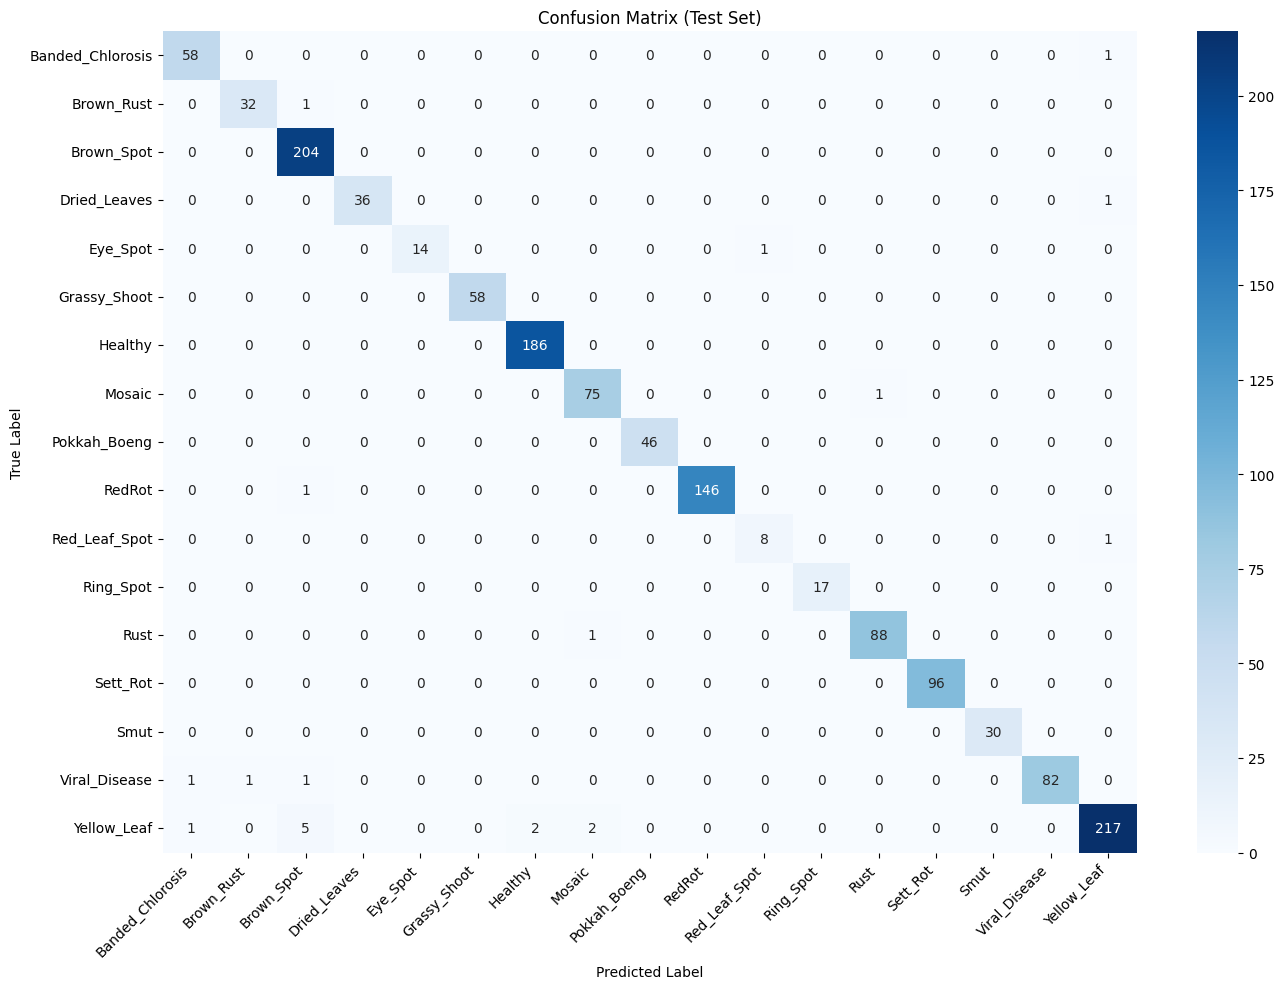

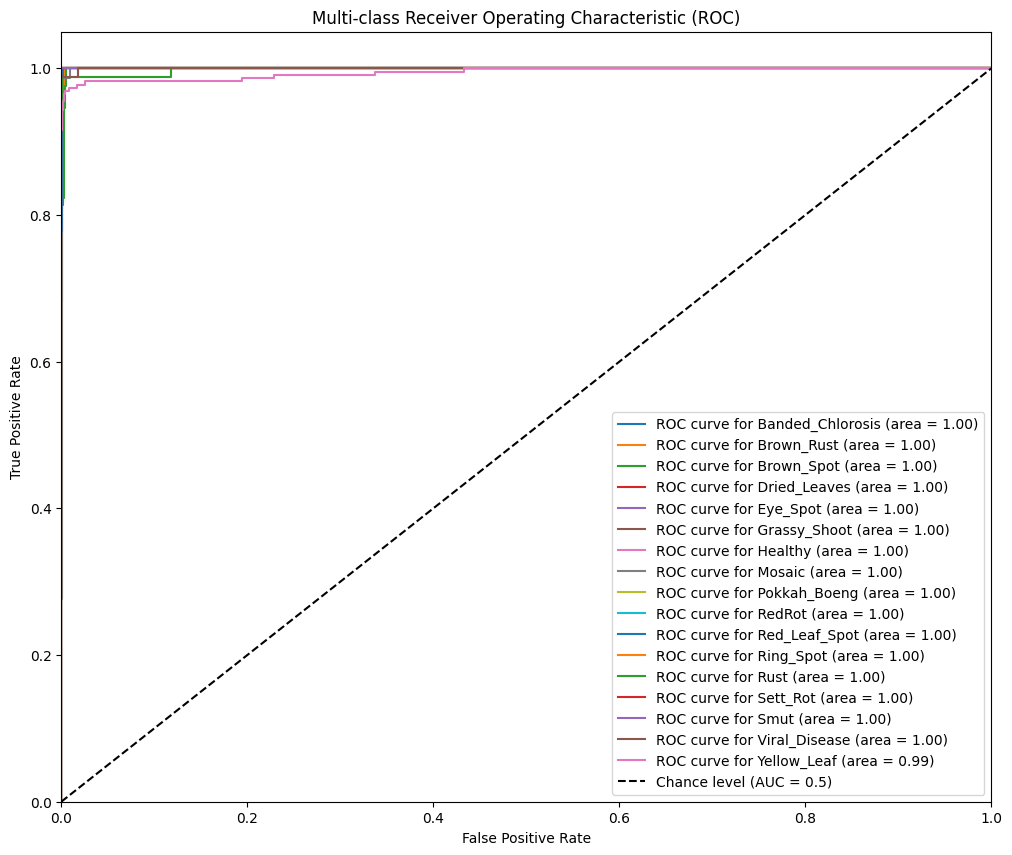

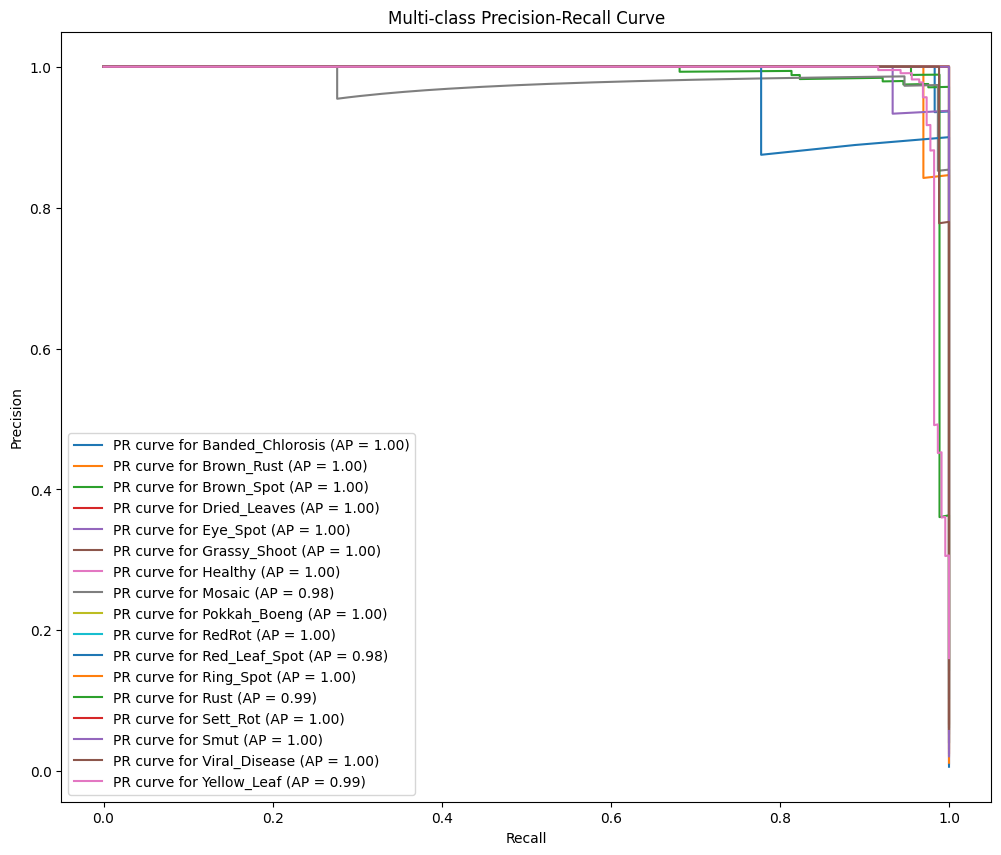

In [21]:
# Get class names in correct order for reports
class_names_report = [int_to_class[i] for i in range(num_classes)]

# # a) Convergence Plots
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history['train_acc'], label='Train Accuracy')
# plt.plot(history['val_acc'], label='Validation Accuracy')
# plt.title('Accuracy vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
# plt.tight_layout()
# plt.savefig('./mnasnet_outputs/convergence_plots.png')
# print("Saved convergence plots to ./mnasnet_outputs/convergence_plots.png")

# b) Classification Report
report = classification_report(test_targets, test_preds, target_names=class_names_report, zero_division=0)
print("\nClassification Report (Test Set):\n", report)
with open("./mnasnet_outputs/classification_report.txt", "w") as f:
    f.write(report)
    
# c) Confusion Matrix
plt.figure(figsize=(14, 10))
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_report, yticklabels=class_names_report)
plt.title('Confusion Matrix (Test Set)'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./mnasnet_outputs/confusion_matrix.png')
print("Saved confusion matrix to ./mnasnet_outputs/confusion_matrix.png")

# Binarize labels for multi-class ROC/PR curves
y_true_bin = label_binarize(test_targets, classes=range(num_classes))

# d) ROC-AUC Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names_report[i]} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)'); plt.legend(loc="lower right")
plt.savefig('./mnasnet_outputs/roc_auc_curve.png')
print("Saved ROC-AUC curve to ./mnasnet_outputs/roc_auc_curve.png")

# e) Precision-Recall Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], test_outputs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], test_outputs[:, i])
    plt.plot(recall, precision, label=f'PR curve for {class_names_report[i]} (AP = {avg_precision:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve'); plt.legend(loc="best")
plt.savefig('./mnasnet_outputs/precision_recall_curve.png')
print("Saved Precision-Recall curve to ./mnasnet_outputs/precision_recall_curve.png")



In [22]:
# # --- 8. t-SNE Visualization ---
# def extract_features(model, loader, device):
#     """
#     Extracts deep features from the model for t-SNE visualization.
#     It temporarily replaces the final classifier with an Identity layer.
#     """
#     features = []
#     labels = []
#     model.eval()
    
#     # The classifier is part of the base_model
#     original_classifier = model.base_model.classifier
#     model.base_model.classifier = nn.Identity()
    
#     with torch.no_grad():
#         for data, target in tqdm(loader, desc="Extracting features for t-SNE"):
#             data = data.to(device)
#             output = model(data)
#             features.append(output.cpu().numpy())
#             labels.append(target.numpy())
            
#     # Restore the original classifier
#     model.base_model.classifier = original_classifier
#     return np.concatenate(features), np.concatenate(labels)

# print("\n--- Generating t-SNE visualizations ---")
# features, tsne_labels = extract_features(best_model, test_loader, device)
# tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(30, len(features)-1), n_iter=1000, init='pca')
# tsne_results = tsne.fit_transform(features)

# # Get prediction confidence scores for the test set
# confidences = np.max(test_outputs, axis=1)

# # f) t-SNE plot colored by true labels
# plt.figure(figsize=(12, 10))
# sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=[class_names_report[l] for l in tsne_labels], palette=sns.color_palette("hsv", num_classes), s=50, alpha=0.7)
# plt.title('t-SNE of Image Features by True Class'); plt.legend(loc='best')
# plt.savefig('./mnasnet_outputs/tsne_by_class.png')
# print("Saved t-SNE plot by class to ./mnasnet_outputs/tsne_by_class.png")

# # g) t-SNE plot colored by confidence
# plt.figure(figsize=(12, 10))
# scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=confidences, cmap='viridis', s=50, alpha=0.7)
# plt.colorbar(scatter, label='Prediction Confidence')
# plt.title('t-SNE of Image Features by Prediction Confidence')
# plt.savefig('./mnasnet_outputs/tsne_by_confidence.png')
# print("Saved t-SNE plot by confidence to ./mnasnet_outputs/tsne_by_confidence.png")

# # h) Confidence Bar Plots for Misclassified Images
# misclassified_indices = np.where(np.array(test_preds) != np.array(test_targets))[0]
# if len(misclassified_indices) > 0:
#     print(f"\nFound {len(misclassified_indices)} misclassified images. Plotting confidence for a few examples.")
#     num_to_plot = min(len(misclassified_indices), 5)
#     fig, axes = plt.subplots(num_to_plot, 1, figsize=(10, num_to_plot * 4))
#     if num_to_plot == 1: axes = [axes] # Make it iterable
#     for i, idx in enumerate(misclassified_indices[:num_to_plot]):
#         true_label = class_names_report[test_targets[idx]]
#         pred_label = class_names_report[test_preds[idx]]
#         probs = test_outputs[idx]
        
#         axes[i].bar(class_names_report, probs, color='skyblue')
#         axes[i].set_title(f"Sample {i+1}: True='{true_label}', Predicted='{pred_label}' (Confidence: {probs[test_preds[idx]]:.2f})")
#         axes[i].set_ylabel("Probability")
#         axes[i].tick_params(axis='x', rotation=45)
#     plt.tight_layout()
#     plt.savefig('./mnasnet_outputs/misclassified_confidence.png')
#     print("Saved confidence plots for misclassified samples to ./mnasnet_outputs/misclassified_confidence.png")
# else:
#     print("\nNo misclassified images found in the test set. Perfect score!")

# print("\nScript finished successfully. All artifacts are in the './mnasnet_outputs' directory.")